In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest


In [3]:
from world import World
from grid_data import Rainfall, SurfaceTemperature
from utils import movmean

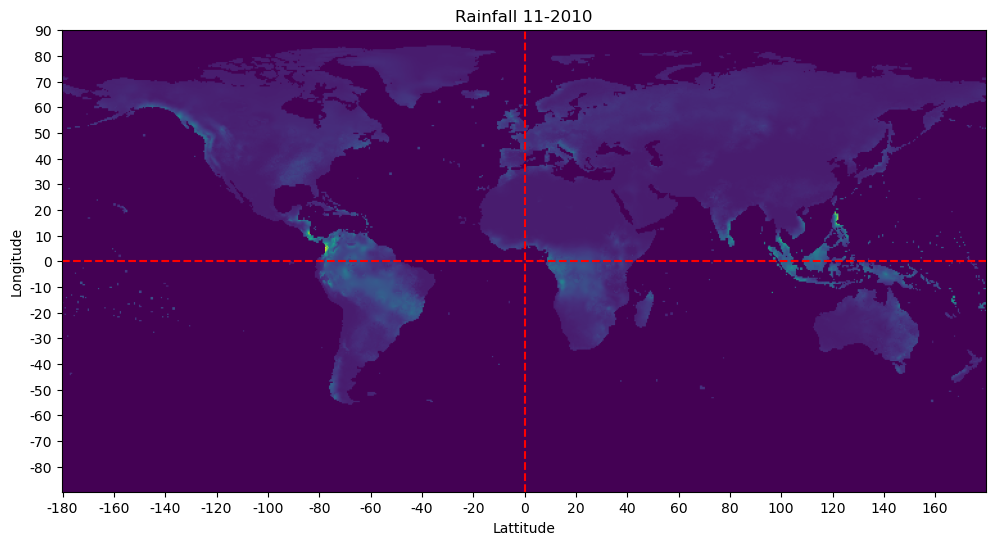

In [4]:
# fetch data
rainfall = Rainfall()
rainfall.fetch_data_years(1901, 2023, delete_file=True)

# get 2001 january for the entire world and plot
ax = rainfall.plot_month(11, 2010)
plt.show()

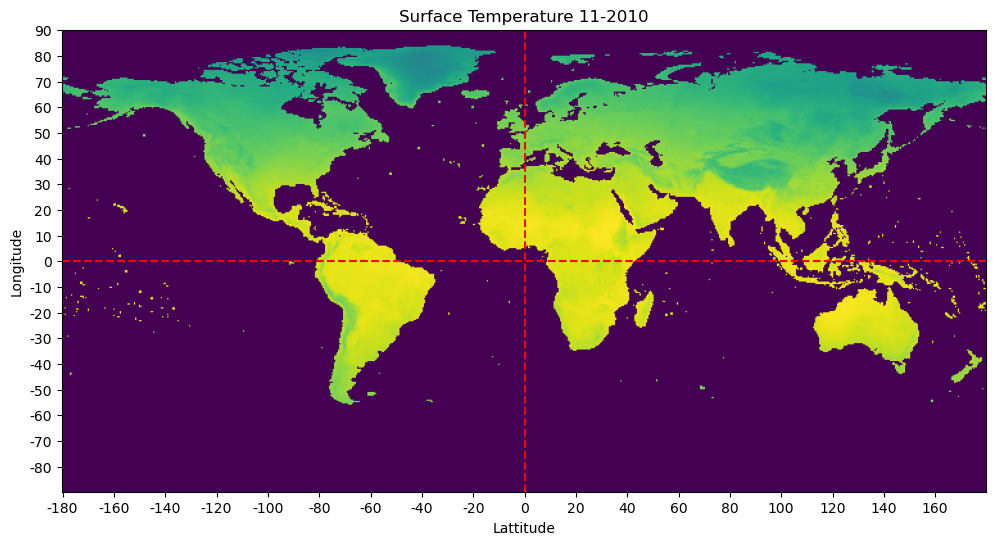

In [5]:
# fetch surface temp data
surf_temp = SurfaceTemperature()
surf_temp.fetch_data_years(1901, 2023, delete_file=True)

ax = surf_temp.plot_month(11, 2010)
plt.show()

In [6]:
data = surf_temp.get_month(11, 2000)
np.amin(data), np.amax(data)

(np.float64(-999.0), np.float64(315.0))

# Create the world object and create lookup array

In [8]:
# create the world object
world = World('tests/aux_files/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world.create_lookup()

### Quick test to see if country selections make sense

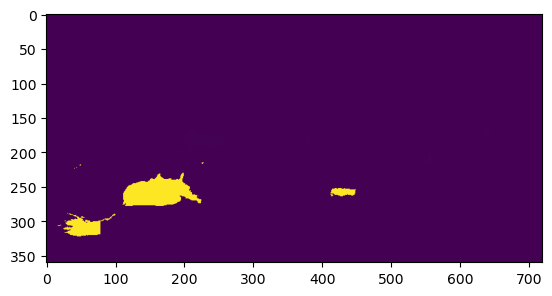

In [9]:
# quick test for selecting country
idx = world.get_grid_points_of_country(iso_code='TUR')
data = np.copy(rainfall.get_month(5, 2007))
data[idx] = 999999
idx = world.get_grid_points_of_country(iso_code='US1')
data[idx] = 999999
plt.imshow(data)
plt.show()

### Plot rainfall totals for Turkey and Syria, just as a test

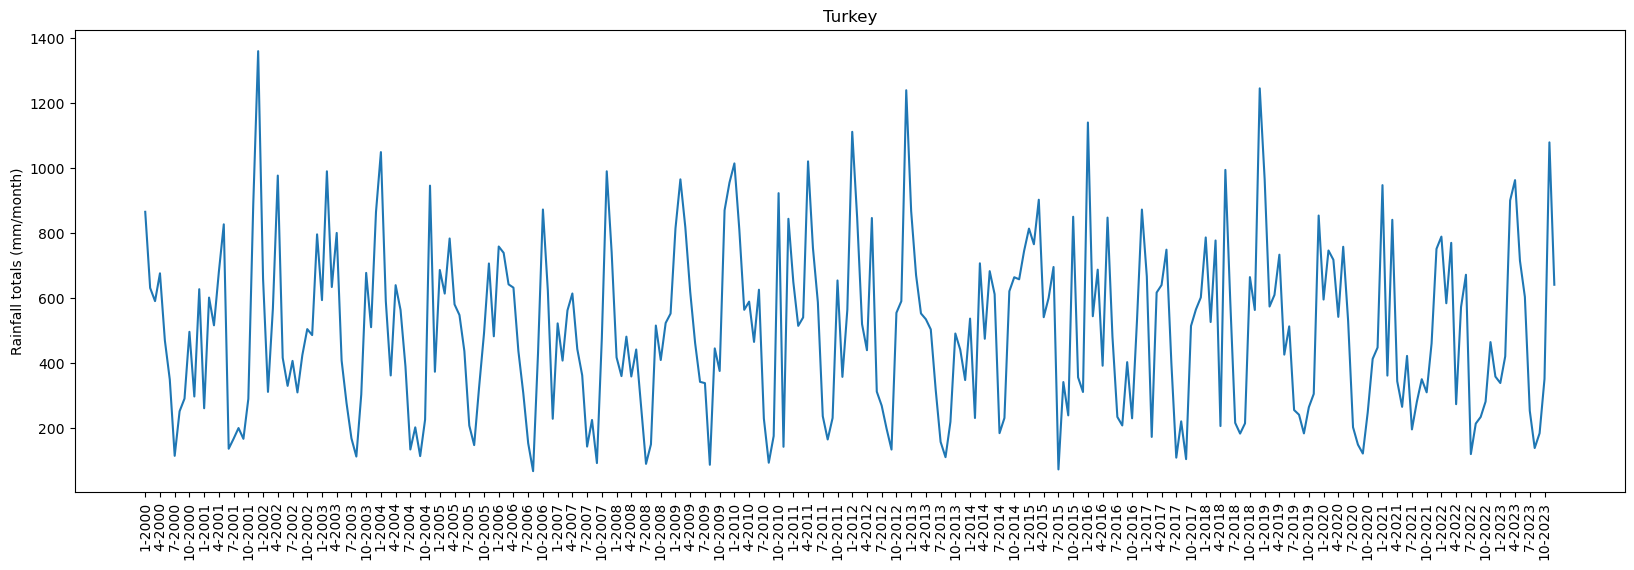

In [10]:
t, dates, totals = rainfall.get_country_avg((1,12), (2000,2023),'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::3])
ax.set_xticklabels(dates[::3], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Turkey')
plt.show()

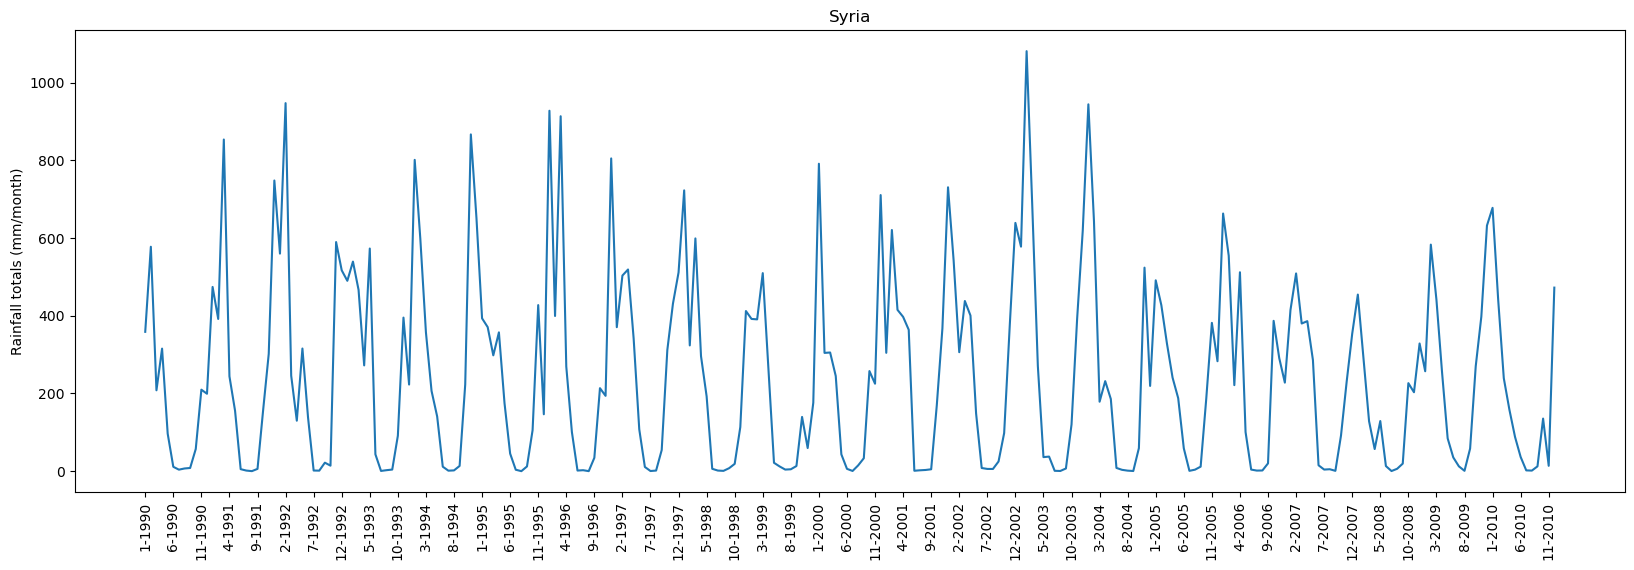

In [11]:
t, dates, totals = rainfall.get_country_avg((1,12), (1990,2010),'SYR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, totals)
ax.set_xticks(t[::5])
ax.set_xticklabels(dates[::5], rotation=90)
ax.set_ylabel('Rainfall totals (mm/month)')
ax.set_title('Syria')
plt.show()

### Syria 6-month winter averages (November-April) as plotted in Fig.1 of [Kelley et al.](https://www.pnas.org/doi/epdf/10.1073/pnas.1421533112)

The orange line is a moving average with a window of 50 years, meant to depict the overall decrease trend starting around ~1990.

p-value for pre 1930s temperature to be larger is 0.07485028305619477, with a test statistic of 1.4405899331246053.


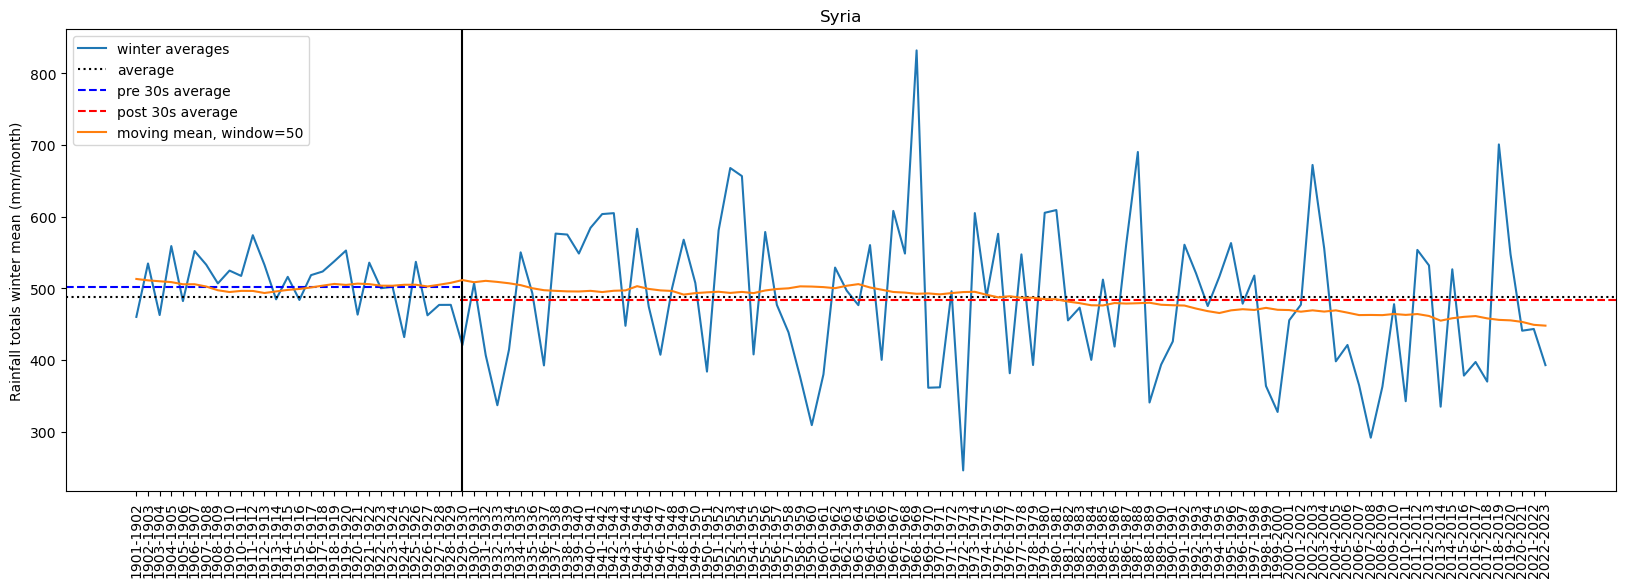

In [13]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)

# quick hypothesis testing with H_0: mu_1=mu_2, H_a: mu_2>mu_1
pre_30s = winter_means[:31]
post_30s = winter_means[31:]
pop_mean_diff = np.mean(post_30s)-np.mean(pre_30s)
z, p = ztest(x1=pre_30s, x2=post_30s, alternative='larger', usevar='unequal')
print(f"p-value for pre 1930s temperature to be larger is {p}, with a test statistic of {z}.")

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter averages')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='average')
ax.axhline(np.mean(winter_means[:31]), color='b', linestyle='dashed', xmax=31/len(dates), label='pre 30s average')
ax.axhline(np.mean(winter_means[31:]), color='r', linestyle='dashed', xmin=31/len(dates), label='post 30s average')
ax.axvline(28, color='k')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')

ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Syria')
ax.legend()
plt.show()

Try different cutoffs for the year for the z-test. (This is probably p-hacking)

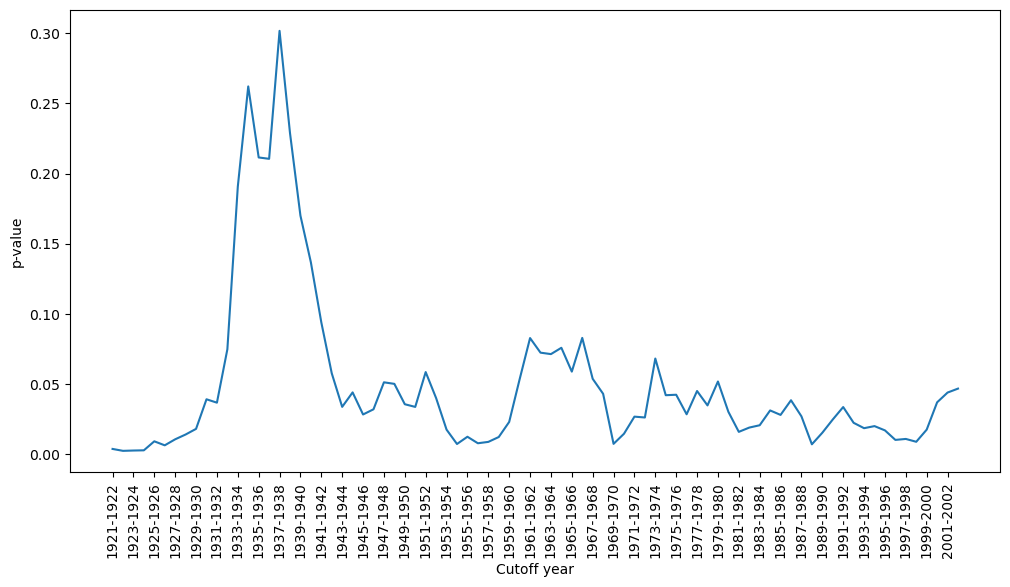

In [14]:
cutoffs = []
pvals = []
margin = 20
for i in range(margin,len(winter_means)-margin):
    pre = winter_means[:i]
    post = winter_means[i:]
    z, p = ztest(x1=pre, x2=post, alternative='larger', usevar='unequal')
    cutoffs.append(i)
    pvals.append(p)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cutoffs, pvals)
ax.set_xlabel('Cutoff year')
ax.set_ylabel('p-value')
ax.set_xticks(cutoffs[::2])
ax.set_xticklabels(dates[margin:-margin][::2], rotation=90)
plt.show()

Same for Turkey, just out of curiosity. Note that a similar trend exists, but the total rainfall is an order of magnitude larger. This suggests to me that maybe if the total rainfall is large enough, the economical impacts of a drought may be more robust to rainfall variation. 

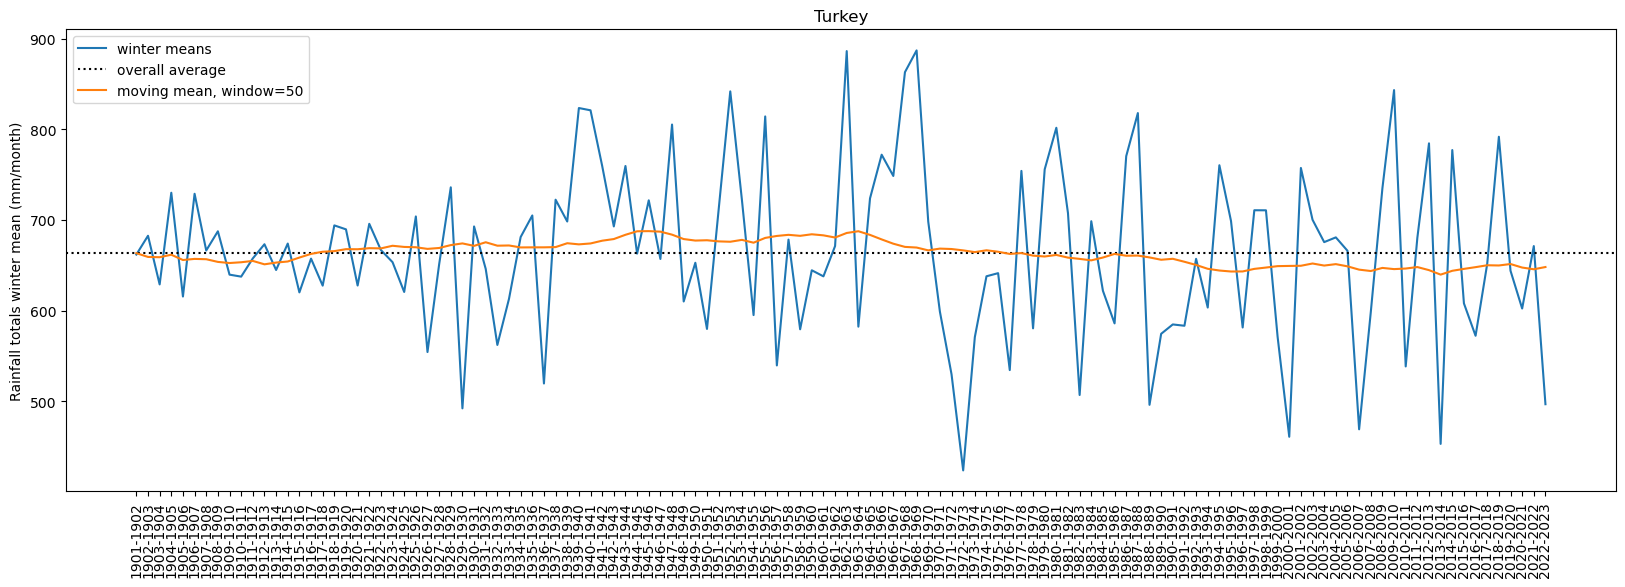

In [15]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t, winter_means, label='winter means')
ax.axhline(np.mean(winter_means), color='k', linestyle='dotted', label='overall average')
ax.plot(t, movmean(winter_means, window=50), label='moving mean, window=50')
ax.set_xticks(t)
ax.set_xticklabels(dates, rotation=90)
ax.set_ylabel('Rainfall totals winter mean (mm/month)')
ax.set_title('Turkey')
ax.legend()
plt.show()

Rainfall variation (as numerical differentiation)

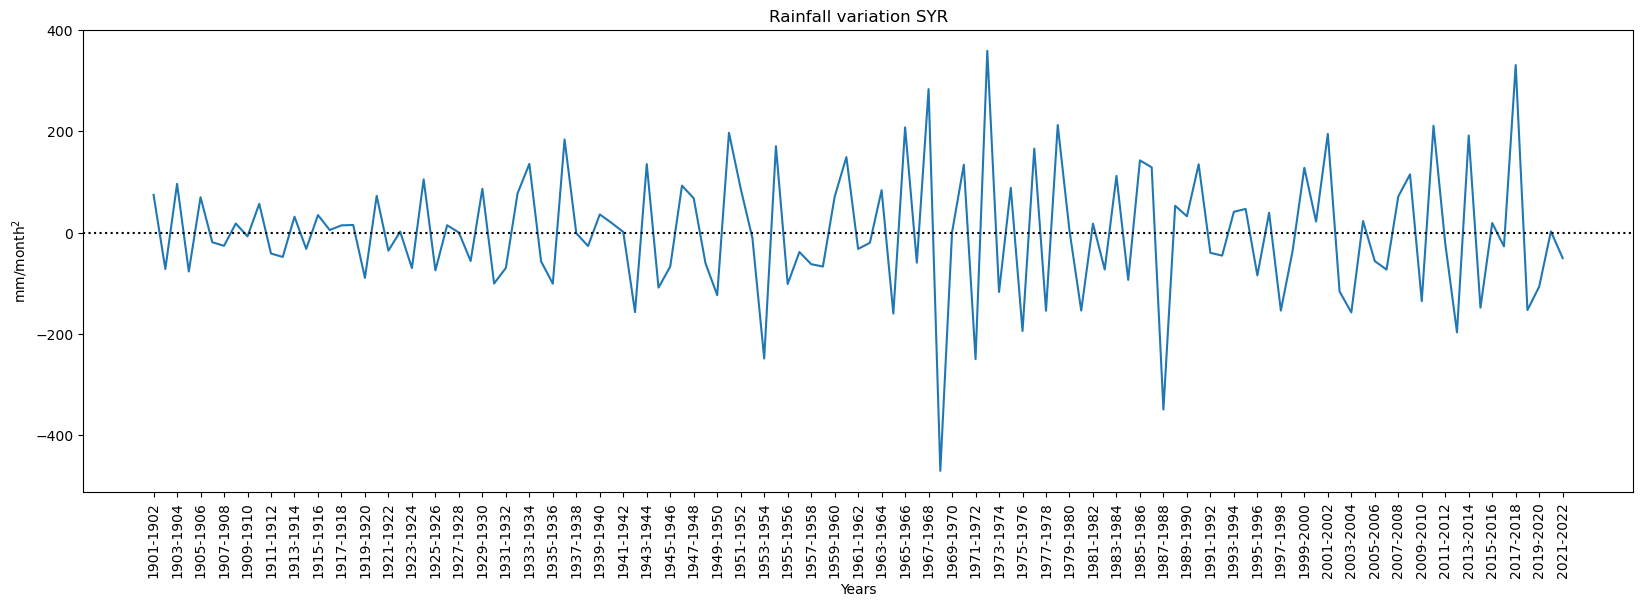

In [19]:
t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = np.diff(winter_means)
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(t[:-1], variation)
ax.set_xticks(t[::2])
ax.set_xticklabels(dates[::2], rotation=90)
ax.axhline(0, color='k', linestyle='dotted')
ax.set_title('Rainfall variation SYR')
ax.set_xlabel('Years')
ax.set_ylabel('mm/month$^2$')
plt.show()

## Compare with GDP

In [20]:
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df.head(5)

,Entity,Code,Year,ny_gdp_mktp_kd
0,Afghanistan,AFG,2000,6.206548e+09
1,Afghanistan,AFG,2001,5.621148e+09
2,Afghanistan,AFG,2002,7.228796e+09
3,Afghanistan,AFG,2003,7.867264e+09
4,Afghanistan,AFG,2004,7.978516e+09


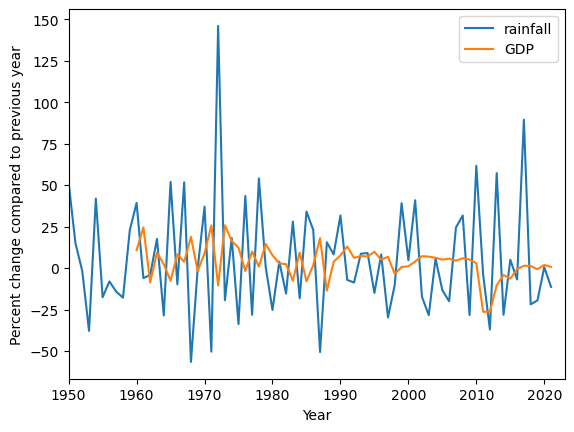

In [21]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022) 

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

OLS attempt at rainfall variation and change in GDP for Syria

[[0.         0.03477456]] 0.015191192251121977


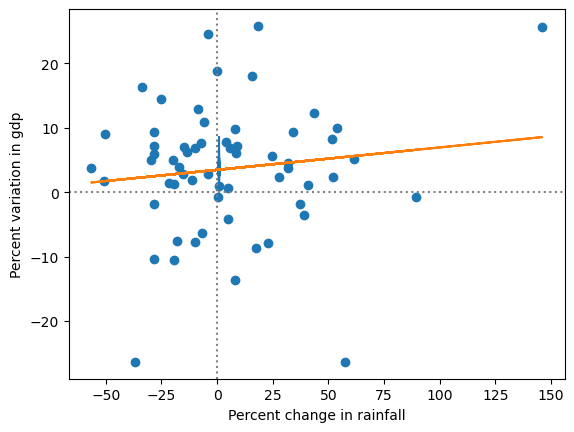

In [22]:
from sklearn.linear_model import LinearRegression

year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1961, 2022)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Percent change in rainfall')
plt.ylabel('Percent variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].to_numpy().reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Same, but not normalized

[[     0.         603848.45102385]] 0.002775611096733299


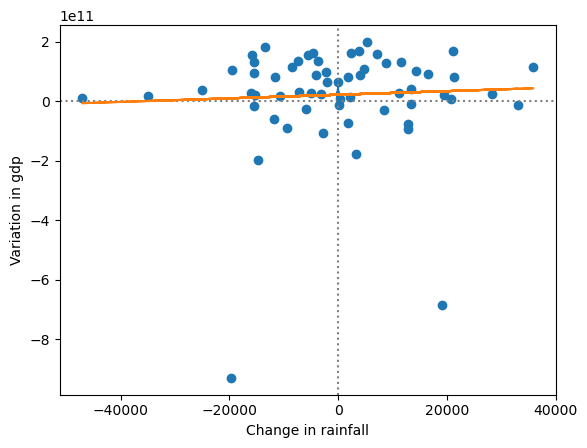

In [23]:
year = df[df['Code'] == 'SYR'].Year

gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)
variation = 100*np.diff(winter_means)

plt.scatter(variation[1:], gdp_var[:-1])
plt.xlabel('Change in rainfall')
plt.ylabel('Variation in gdp')
plt.axhline(0, color='gray', linestyle='dotted')
plt.axvline(0, color='gray', linestyle='dotted')

X = np.hstack((np.ones((len(variation[1:]), 1)), variation[1:].reshape(-1, 1)))
y = gdp_var[:-1].reshape(-1, 1)
reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))
plt.plot(X, reg.predict(X))
plt.show()

Plotting rainfall variation and change in GDP for Turkey

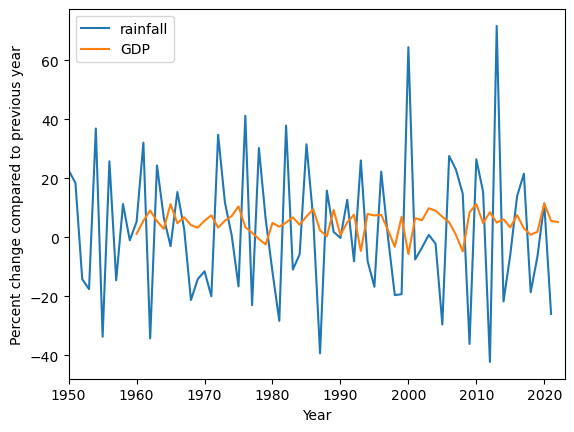

In [24]:
year = df[df['Code'] == 'TUR'].Year

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp_var = 100*np.diff(gdp)/gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1901,2023), 'TUR', world)
variation = 100*np.diff(winter_means)/winter_means[:-1]
tx = np.arange(1901, 2022)

plt.plot(tx, variation, label='rainfall')
plt.plot(year[:-1], gdp_var, label='GDP')
plt.xlabel('Year')
plt.ylabel('Percent change compared to previous year')
plt.xlim(1950,2023)
plt.legend()
plt.show()

## Function to calculate variations as described in [Miguel et al. 2004](http://emiguel.econ.berkeley.edu/wordpress/wp-content/uploads/2021/03/Paper__Economic_Shocks_and_Civil_Conflict.pdf):

For rainfall $R$, the variation is
$$
\Delta R_{it} = \frac{R_{it}-R_{i,t-1}}{R_{i,t-1}},
$$
where $i$ denotes the country and $t$ denotes the year.

In [27]:
from utils import diff

# Basic OLS attempts

In [29]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'SYR'].Year
gdp = df[df['Code'] == 'SYR'].ny_gdp_mktp_kd

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'SYR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))

[[ 0.         -0.05400169  0.08884867 -0.00192038]] 0.3197112384553029


In [31]:
# design matrix roughly following the rainfall paper

year = df[df['Code'] == 'TUR'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TUR'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TUR', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.00000000e+00 -4.59480862e-02 -9.64450884e-03 -7.11028183e-05]] 0.06976567207913531


In [33]:
year = df[df['Code'] == 'RWA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'RWA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'RWA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[ 0.          0.01435919 -0.01330404  0.00079599]] 0.02471973145890427


In [34]:
year = df[df['Code'] == 'TZA'].Year
year = year[:-1]

gdp = df[df['Code'] == 'TZA'].ny_gdp_mktp_kd
gdp = gdp[:-1]

t, dates, winter_means = rainfall.get_country_winter_mean((1960,2023), 'TZA', world)

r_it = diff(winter_means)
r_it_1 = diff(winter_means, lag=1)


X = np.hstack((np.ones((len(r_it_1), 1)), r_it[1:].reshape(-1, 1)))
X = np.hstack((X, r_it_1.reshape(-1, 1)))
X = np.hstack((X, year[2:].to_numpy().reshape(-1, 1)))

gdp_var = diff(gdp)
y = gdp_var[1:].reshape(-1, 1)

reg = LinearRegression().fit(X, y)
print(reg.coef_, reg.score(X, y))


[[0.         0.02506661 0.01809996 0.00082745]] 0.04922830434691261


# Join multiple datasets

- Annual GDP data
- Annual winter rainfall data
- Share of GDP from agriculture
- Oil rents as a share of GDP
- Democracy index Polity V
- Ethnic fractionalization index

In [35]:
from csv_fetcher import CsvFetcher

In [36]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/agriculture-share-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
agricultural_share = fetcher.fetch()
agricultural_share.head(5)

iso_name = agricultural_share.copy()
iso_name = iso_name[['Entity', 'Code']].drop_duplicates(ignore_index=True)

In [37]:
agricultural_share[agricultural_share.isna().any(axis=1)]

# remove region info
agricultural_share.dropna(inplace=True)


In [38]:
iso_name

,Entity,Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Andorra,AND
4,Angola,AGO
...,...,...
215,Vietnam,VNM
216,World,OWID_WRL
217,Yemen,YEM
218,Zambia,ZMB


In [39]:
print(agricultural_share['Code'].unique(), agricultural_share['Code'].nunique())

['AFG' 'ALB' 'DZA' 'AND' 'AGO' 'ATG' 'ARG' 'ARM' 'ABW' 'AUS' 'AUT' 'AZE'
 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN' 'BOL' 'BIH'
 'BWA' 'BRA' 'BRN' 'BGR' 'BFA' 'BDI' 'KHM' 'CMR' 'CAN' 'CPV' 'CYM' 'CAF'
 'TCD' 'OWID_CIS' 'CHL' 'CHN' 'COL' 'COM' 'COG' 'CRI' 'CIV' 'HRV' 'CUB'
 'CUW' 'CYP' 'CZE' 'COD' 'DNK' 'DJI' 'DMA' 'DOM' 'TLS' 'ECU' 'EGY' 'SLV'
 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH' 'FJI' 'FIN' 'FRA' 'PYF' 'GAB' 'GMB' 'GEO'
 'DEU' 'GHA' 'GRC' 'GRL' 'GRD' 'GTM' 'GIN' 'GNB' 'GUY' 'HTI' 'HND' 'HKG'
 'HUN' 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN'
 'JOR' 'KAZ' 'KEN' 'KIR' 'OWID_KOS' 'KWT' 'KGZ' 'LAO' 'LVA' 'LBN' 'LSO'
 'LBR' 'LBY' 'LIE' 'LTU' 'LUX' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL'
 'MRT' 'MUS' 'MEX' 'FSM' 'MDA' 'MNG' 'MNE' 'MAR' 'MOZ' 'MMR' 'NAM' 'NPL'
 'NLD' 'NCL' 'NZL' 'NIC' 'NER' 'NGA' 'MKD' 'NOR' 'OMN' 'PAK' 'PLW' 'PSE'
 'PAN' 'PNG' 'PRY' 'PER' 'PHL' 'POL' 'PRT' 'PRI' 'QAT' 'ROU' 'RUS' 'RWA'
 'KNA' 'LCA' 'VCT' 'WSM' 'SMR' 'STP' 'SAU' 'SEN' 'SRB

In [40]:
from missing_value_handler import add_missing_years, fill_na

In [41]:
agricultural_share = add_missing_years(agricultural_share,
                                       min_year=1960,
                                       max_year=2023,
                                       year_name='Year',
                                       ref_column='Code')

In [42]:
agricultural_share[agricultural_share['Code']=='AFG']
agricultural_share = agricultural_share.drop('Entity', axis=1)

In [43]:
fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', 'AFG', method='max')
agricultural_share[agricultural_share['Code']=='AFG']

,Code,Year,nv_agr_totl_zs
0,AFG,2002,38.627890
1,AFG,2003,37.418854
2,AFG,2004,29.721067
3,AFG,2005,31.114855
4,AFG,2006,28.635970
...,...,...,...
0,AFG,1997,38.627890
0,AFG,1998,38.627890
0,AFG,1999,38.627890
0,AFG,2000,38.627890


In [44]:
# do the same to all the other countries
for country in agricultural_share['Code'].unique():
    fill_na(agricultural_share, 'nv_agr_totl_zs', 'Code', country, method='max')

agricultural_share = agricultural_share.sort_values(by=['Code','Year'])

In [45]:
agricultural_share.sample(10)

,Code,Year,nv_agr_totl_zs
5179,MHL,1999,7.963593
7552,SOM,1960,64.445335
7268,SRB,2006,6.222232
0,FJI,1960,37.840466
9239,ZMB,1968,11.386888
2074,CZE,2007,2.088715
0,ARM,1996,18.434763
8880,USA,2010,1.029437
2360,TLS,2000,28.427390
0,IMN,1974,0.642657


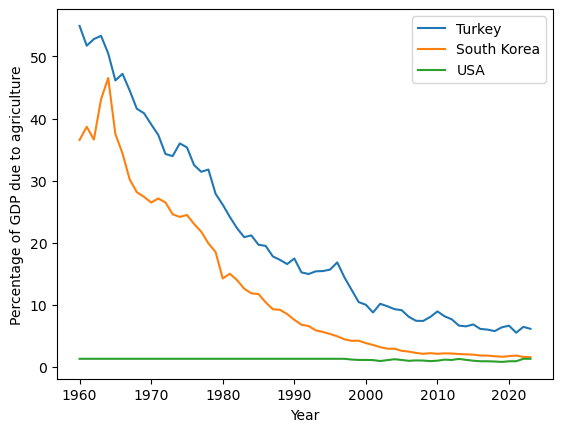

In [46]:
test = agricultural_share[agricultural_share['Code']=='TUR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='Turkey')

test = agricultural_share[agricultural_share['Code']=='KOR']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='South Korea')

test = agricultural_share[agricultural_share['Code']=='USA']
plt.plot(test['Year'], test['nv_agr_totl_zs'], label='USA')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to agriculture')
plt.show()

In [47]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/oil-rents-as-a-share-of-gdp.csv?v=1&csvType=full&useColumnShortNames=true')
oil_rent = fetcher.fetch()
oil_rent = oil_rent.drop('Entity', axis=1)
oil_rent = oil_rent.dropna()
oil_rent = add_missing_years(oil_rent,
                             min_year=1960,
                             max_year=2023,
                             year_name='Year',
                             ref_column='Code')

for country in oil_rent['Code'].unique():
    fill_na(oil_rent, 'ny_gdp_petr_rt_zs', 'Code', country, method='min')

oil_rent = oil_rent.sort_values(by=['Code', 'Year'])
oil_rent.reset_index(drop=True, inplace=True)

oil_rent.sample(10)

,Code,Year,ny_gdp_petr_rt_zs
1411,BLZ,1963,0.000000
1633,BRA,1993,0.627723
7362,MEX,1962,0.204289
8164,NAM,1996,0.000000
3680,EST,1992,0.233222
11316,THA,2012,1.640991
5194,IDN,1970,0.336862
2814,CUB,2022,0.004771
12571,YEM,1987,0.681566
8844,OWID_KOS,1972,0.000000


In [48]:
oil_rent[oil_rent.isna().any(axis=1)]

,Code,Year,ny_gdp_petr_rt_zs


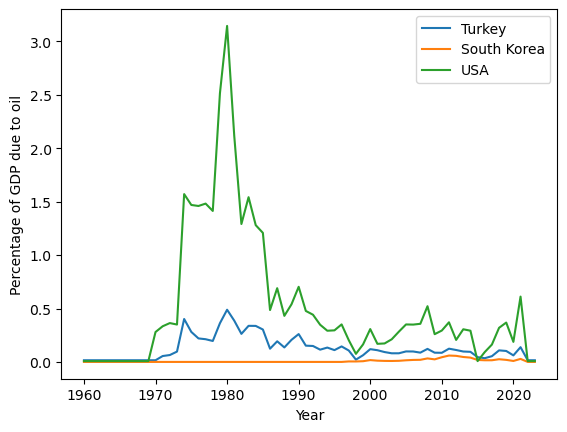

In [49]:
test = oil_rent[oil_rent['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='Turkey')

test = oil_rent[oil_rent['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='South Korea')

test = oil_rent[oil_rent['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_petr_rt_zs'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of GDP due to oil') # is this true?
plt.show()

In [50]:
fetcher = CsvFetcher('https://ourworldindata.org/grapher/democracy-index-polity.csv?v=1&csvType=full&useColumnShortNames=true')
democracy_index = fetcher.fetch()
democracy_index = democracy_index.drop('Entity', axis=1)
democracy_index = add_missing_years(democracy_index,
                                    min_year=1960,
                                    max_year=2023,
                                    year_name='Year',
                                    ref_column='Code')

for country in democracy_index['Code'].unique():
    fill_na(democracy_index, 'democracy_polity', 'Code', country, method='mean')

democracy_index = democracy_index.sort_values(by=['Code','Year'])

democracy_index.head(5)

,Code,Year,democracy_polity
0,AFG,1800,-6.0
1,AFG,1801,-6.0
2,AFG,1802,-6.0
3,AFG,1803,-6.0
4,AFG,1804,-6.0


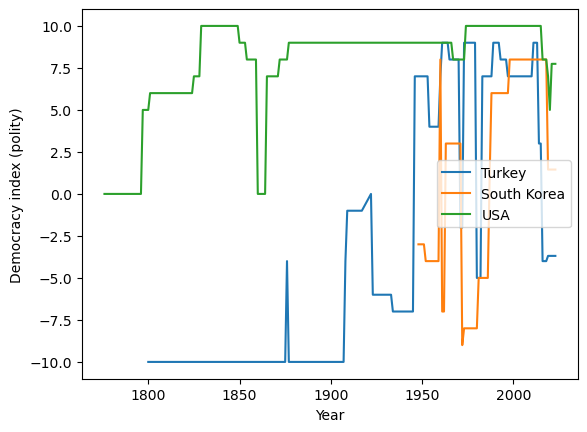

In [51]:
test = democracy_index[democracy_index['Code'] == 'TUR']
plt.plot(test['Year'], test['democracy_polity'], label='Turkey')

test = democracy_index[democracy_index['Code'] == 'KOR']
plt.plot(test['Year'], test['democracy_polity'], label='South Korea')

test = democracy_index[democracy_index['Code'] == 'USA']
plt.plot(test['Year'], test['democracy_polity'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Democracy index (polity)')
plt.show()

In [52]:
fetcher = CsvFetcher('https://cadmus.eui.eu/bitstream/handle/1814/64606/Historical_Index_of_Ethnic_Fractionalisation_Dataset.csv?sequence=3&isAllowed=y')
ethnic_fractionation = fetcher.fetch()
ethnic_fractionation = add_missing_years(ethnic_fractionation,
                                         min_year=1960,
                                         max_year=2023,
                                         year_name='Year',
                                         ref_column='Country')

for country in ethnic_fractionation['Country'].unique():
    fill_na(ethnic_fractionation, 'EFindex', 'Country', country, method='max')

ethnic_fractionation = ethnic_fractionation.sort_values(by=['Country', 'Year'])
ethnic_fractionation.rename(columns={'Country':'Entity'}, inplace=True)
ethnic_fractionation.sample(10)

,Entity,Year,EFindex
1167,Italy,1949,0.033
1102,Czechoslovakia,1974,0.488
8468,Philippines,1973,0.830
0,East Timor,1989,0.864
367,Spain,1967,0.475
8719,New Zealand,2005,0.426
0,Macedonia,1977,0.562
0,Estonia,1986,0.520
0,Czech Republic,1975,0.371
2276,Benin,2001,0.776


In [54]:
print(ethnic_fractionation['Entity'].unique(), ethnic_fractionation['Entity'].nunique())

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia-Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Canada'
 'Cape Verde' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Czechoslovakia' "Democratic People's Republic of Korea"
 'Democratic Republic of Congo' 'Democratic Republic of Vietnam' 'Denmark'
 'Djibouti' 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'Gabon'
 'Gambia' 'Georgia' 'German Democratic Republic' 'German Federal Republic'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hungary' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Kuwait'
 'Kyrgyz Republ

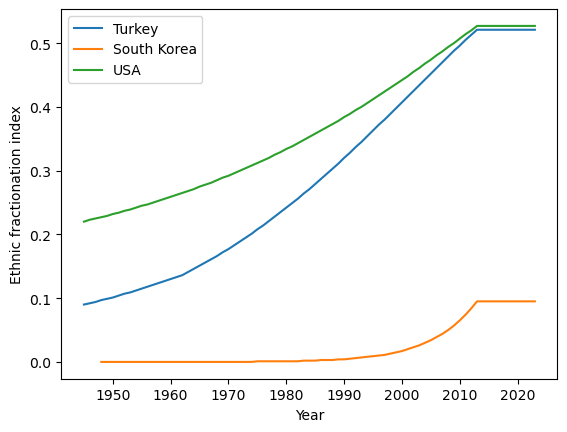

In [56]:
test = ethnic_fractionation[ethnic_fractionation['Entity']=='Turkey']
plt.plot(test['Year'], test['EFindex'], label='Turkey')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='Republic of Korea']
plt.plot(test['Year'], test['EFindex'], label='South Korea')

test = ethnic_fractionation[ethnic_fractionation['Entity']=='United States of America']
plt.plot(test['Year'], test['EFindex'], label='USA')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Ethnic fractionation index')
plt.show()

In [57]:
# our gdp dataset we downloaded above
df = pd.read_csv("https://ourworldindata.org/grapher/gdp-worldbank-constant-usd.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

df = df.drop('Entity', axis=1)
df = add_missing_years(df, min_year=1960,
                       max_year=2023,
                       year_name='Year',
                       ref_column='Code')

for country in df['Code'].unique():
    fill_na(df, 'ny_gdp_mktp_kd', 'Code', country, method='min')

df = df.sort_values(by=['Code', 'Year'])

df.sample(5)

,Code,Year,ny_gdp_mktp_kd
1321,BWA,1998,7.592496e+09
7413,MAR,1995,4.538087e+10
9706,SGP,1992,8.068162e+10
1192,BOL,1967,6.762932e+09
8280,PAK,1960,1.892191e+10


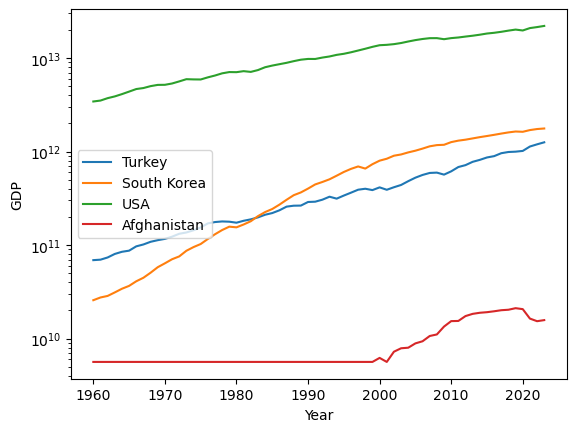

In [59]:
test = df[df['Code']=='TUR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Turkey')

test = df[df['Code']=='KOR']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='South Korea')

test = df[df['Code']=='USA']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='USA')

test = df[df['Code']=='AFG']
plt.plot(test['Year'], test['ny_gdp_mktp_kd'], label='Afghanistan')


plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.yscale('log')
plt.show()

In [60]:
ethnic_fractionation_with_code = ethnic_fractionation.merge(iso_name, on=['Entity'])
ethnic_fractionation_with_code.sample(10)

,Entity,Year,EFindex,Code
8170,Serbia,2021,0.596,SRB
6159,Mexico,1993,0.570,MEX
179,Algeria,1981,0.339,DZA
2619,Denmark,1950,0.007,DNK
383,Armenia,1975,0.137,ARM
5951,Mali,1992,0.853,MLI
8443,Solomon Islands,1974,0.121,SLB
9130,Tajikistan,1991,0.553,TJK
2735,Djibouti,2002,0.651,DJI
967,Benin,2002,0.776,BEN


### Finally joining datasets

In [68]:
new_df = agricultural_share.merge(oil_rent, on=['Code', 'Year'])
new_df = new_df.merge(democracy_index, on=['Code', 'Year'])
new_df = new_df.merge(df, on=['Code', 'Year'])
new_df = new_df.merge(ethnic_fractionation_with_code, on=['Code', 'Year'])

new_df.rename(columns={'Code':'ISO3_code',
                       'nv_agr_totl_zs':'pt_gdp_agriculture',
                       'nv_gdp_petr_rt_zs':'pt_gdp_oil',
                       'ny_gdp_mktp_kd':'gdp',
                       'Entity':'country',
                       'EFindex': 'ethnic_fractionation_index'},
                       inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.sample(20)

,ISO3_code,Year,pt_gdp_agriculture,ny_gdp_petr_rt_zs,democracy_polity,gdp,country,ethnic_fractionation_index
2092,CRI,2001,8.379537,0.000000,10.0,3.148721e+10,Costa Rica,0.365
7970,SWE,1976,4.659801,0.000153,10.0,2.273784e+11,Sweden,0.143
7075,ROU,1978,21.809069,0.183645,-8.0,9.252425e+10,Romania,0.207
6963,PRY,1995,18.443783,0.000000,7.0,2.035811e+10,Paraguay,0.151
2731,ESP,2000,3.744311,0.004835,10.0,9.779647e+11,Spain,0.628
5437,MDG,2005,30.762733,0.000000,7.0,8.640170e+09,Madagascar,0.120
9061,ZMB,1977,16.391462,0.000000,-9.0,6.138990e+09,Zambia,0.798
2762,EST,1967,5.051828,0.233222,-7.0,9.855880e+09,Estonia,0.520
7809,SRB,2007,5.504866,0.420166,8.0,4.009142e+10,Serbia,0.414
9058,ZMB,1974,10.645454,0.000000,-9.0,6.196473e+09,Zambia,0.800


## Add rainfall and surface temp data

In [62]:
countries = new_df['ISO3_code'].unique()
print(countries, len(countries))

['AFG' 'AGO' 'ALB' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BLR' 'BOL' 'BRA' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE'
 'CHL' 'CHN' 'CIV' 'COD' 'COG' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'DJI'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'GAB'
 'GBR' 'GEO' 'GHA' 'GIN' 'GMB' 'GNB' 'GRC' 'GTM' 'GUY' 'HND' 'HRV' 'HTI'
 'HUN' 'IDN' 'IRL' 'IRN' 'IRQ' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KHM' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LKA' 'LSO' 'LTU' 'LVA' 'MAR' 'MDA'
 'MDG' 'MEX' 'MLI' 'MMR' 'MNG' 'MRT' 'MUS' 'MWI' 'MYS' 'NAM' 'NER' 'NGA'
 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'POL' 'PRT'
 'PRY' 'QAT' 'ROU' 'RUS' 'RWA' 'SAU' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV'
 'SOM' 'SRB' 'SVK' 'SVN' 'SWE' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TKM' 'TLS'
 'TTO' 'TUN' 'TUR' 'TZA' 'UGA' 'UKR' 'URY' 'UZB' 'ZAF' 'ZMB' 'ZWE'] 143


In [79]:
yearly_rainfall = pd.DataFrame()
yearly_temp_avg = pd.DataFrame()
for country in countries:
    try:
        t, years, averages = rainfall.get_country_annual_avg((1960, 2023), country, world)
        variation = diff(averages)
        variation = np.concatenate(([variation[0]], variation))
        variation_t_1 = diff(averages, lag=1)
        variation_t_1 = np.concatenate(([variation_t_1[0], variation_t_1[0]], variation_t_1))
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_rainfall': averages, 'rainfall_var_t': variation, 'rainfall_var_t_1': variation_t_1})
        yearly_rainfall = pd.concat([yearly_rainfall, to_add])

        t, years, averages = surf_temp.get_country_annual_avg((1960, 2023), country, world)
        variation = diff(averages)
        variation = np.concatenate(([variation[0]], variation))
        variation_t_1 = diff(averages, lag=1)
        variation_t_1 = np.concatenate(([variation_t_1[0], variation_t_1[0]], variation_t_1))
        to_add = pd.DataFrame({'ISO3_code': [country]*len(t), 'Year': years, 'yearly_avg_temp': averages, 'temp_var_t': variation, 'temp_var_t_1': variation_t_1})
        yearly_temp_avg = pd.concat([yearly_temp_avg, to_add])
    except:
        continue

In [80]:
yearly_rainfall

,ISO3_code,Year,yearly_avg_rainfall,rainfall_var_t,rainfall_var_t_1
0,AFG,1960,318.565807,-0.075064,-0.075064
1,AFG,1961,294.653108,-0.075064,-0.075064
2,AFG,1962,243.503638,-0.173592,-0.075064
3,AFG,1963,307.702050,0.263645,-0.173592
4,AFG,1964,300.362434,-0.023853,0.263645
...,...,...,...,...,...
59,ZWE,2019,647.373718,0.176221,-0.316445
60,ZWE,2020,586.835256,-0.093514,0.176221
61,ZWE,2021,543.462821,-0.073909,-0.093514
62,ZWE,2022,635.176282,0.168758,-0.073909


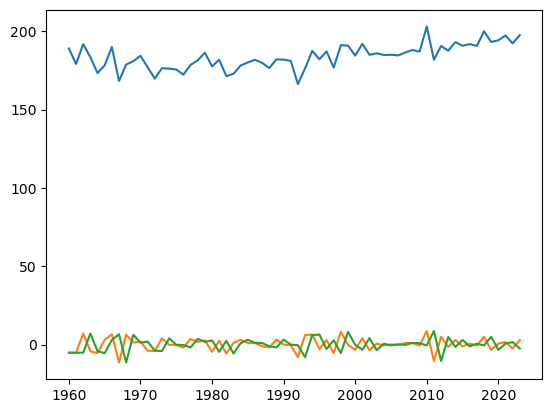

In [87]:
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['yearly_avg_temp'])
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['temp_var_t']*100)
plt.plot(yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['Year'], yearly_temp_avg[yearly_temp_avg['ISO3_code']=='SYR']['temp_var_t_1']*100)

plt.show()

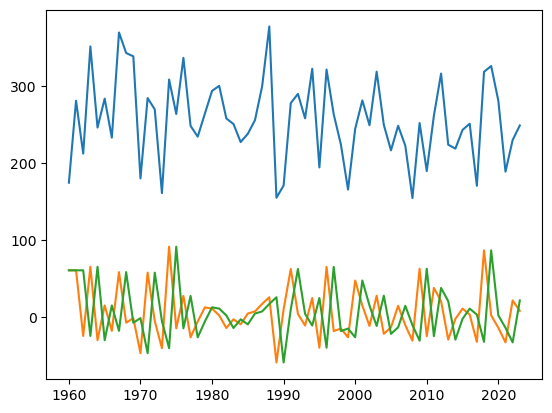

In [88]:
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['yearly_avg_rainfall'])
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t']*100)
plt.plot(yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['Year'], yearly_rainfall[yearly_rainfall['ISO3_code']=='SYR']['rainfall_var_t_1']*100)

plt.show()

In [89]:
dataset = new_df.merge(yearly_rainfall, on=['ISO3_code', 'Year']).merge(yearly_temp_avg, on=['ISO3_code', 'Year'])

In [90]:
dataset.rename(columns={'ny_gdp_petr_rt_zs':'oil_rent'}, inplace=True)
dataset

,ISO3_code,Year,pt_gdp_agriculture,oil_rent,democracy_polity,gdp,country,ethnic_fractionation_index,yearly_avg_rainfall,rainfall_var_t,rainfall_var_t_1,yearly_avg_temp,temp_var_t,temp_var_t_1
0,AFG,1960,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.586,318.565807,-0.075064,-0.075064,116.206019,0.036755,0.036755
1,AFG,1961,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.588,294.653108,-0.075064,-0.075064,120.477183,0.036755,0.036755
2,AFG,1962,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.591,243.503638,-0.173592,-0.075064,117.250992,-0.026778,0.036755
3,AFG,1963,38.627890,0.005149,-10.000000,5.621148e+09,Afghanistan,0.593,307.702050,0.263645,-0.173592,126.046296,0.075013,-0.026778
4,AFG,1964,38.627890,0.005149,-7.000000,5.621148e+09,Afghanistan,0.596,300.362434,-0.023853,0.263645,110.172619,-0.125935,0.075013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8205,ZWE,2019,9.819262,0.050883,-1.692308,2.062108e+10,Zimbabwe,0.415,647.373718,0.176221,-0.316445,224.837821,0.011953,0.012139
8206,ZWE,2020,8.772859,0.029129,-1.692308,1.900914e+10,Zimbabwe,0.415,586.835256,-0.093514,0.176221,220.788462,-0.018010,0.011953
8207,ZWE,2021,8.849899,0.047769,-1.692308,2.061884e+10,Zimbabwe,0.415,543.462821,-0.073909,-0.093514,220.451923,-0.001524,-0.018010
8208,ZWE,2022,7.170550,0.000000,-1.692308,2.188468e+10,Zimbabwe,0.415,635.176282,0.168758,-0.073909,219.669872,-0.003547,-0.001524
